<a href="https://colab.research.google.com/github/larionovskii/practice_2025/blob/main/practice2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Установка пакетов

In [ ]:
!pip install numpy scipy matplotlib

2. Импорты и параметры

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Параметры модели Лотки–Вольтерры
a, b, c, d = 1.0, 0.1, 1.5, 0.075
x_target = np.array([20.0, 10.0])  # целевые значения

3. Класс нейросети и вспомогательные переменные

In [ ]:
class SimpleNN:
    def __init__(self):
        self.W = np.random.randn(2, 2) * 1e-3
        self.b = np.zeros(2)
    def predict(self, e):
        return self.W @ e + self.b
    def train(self, e, u_desired, lr=0.005):
        self.W += lr * np.outer(u_desired, e)
        self.b += lr * u_desired
        self.W = np.clip(self.W, -10, 10)
        self.b = np.clip(self.b, -10, 10)

nn = SimpleNN()
use_control = True
u_hist = []

# PID-коэффициенты для быстрого схождения
Kp = np.array([2.0, 2.0])  # пропорциональные
Kd = np.array([0.5, 0.5])  # дифференциальные
prev_e = np.zeros(2)

4. Функция модели

In [ ]:
def model(t, state):
    global prev_e
    x1, x2 = state
    x = np.array([x1, x2])
    e = x - x_target
    de = e - prev_e
    prev_e = e.copy()

    # PD-контроллер
    u_p = -Kp * e
    u_d = -Kd * de
    u_desired = u_p + u_d

    if use_control:
        nn.train(e, u_desired, lr=0.005)  # учим сеть копировать PD
        u = nn.predict(e)
    else:
        u = u_desired

    u = np.clip(u, -50, 50)
    u_hist.append(u.copy())

    dx1 = x1 * (a - b * x2) + u[0]
    dx2 = -x2 * (c - d * x1) + u[1]
    dx1 = max(dx1, -x1)
    dx2 = max(dx2, -x2)
    return [dx1, dx2]

5. Интегрирование и сбор данных


In [ ]:
x0 = [5.0, 35.0]
t_span = [0, 80]
t_eval = np.linspace(*t_span, 2000)

sol = solve_ivp(model, t_span, x0, t_eval=t_eval, method='RK45')
t = sol.t
x1_vals, x2_vals = sol.y

6. Построение графиков


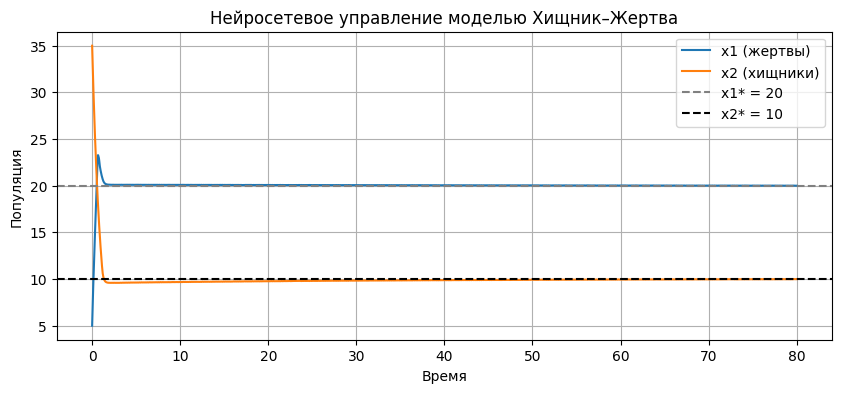

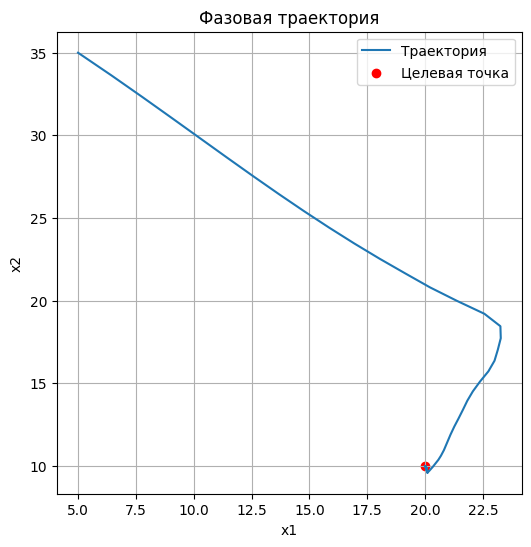

In [ ]:
# Популяции во времени
plt.figure(figsize=(10,4))
plt.plot(t, x1_vals, label='x1 (жертвы)')
plt.plot(t, x2_vals, label='x2 (хищники)')
plt.axhline(x_target[0], linestyle='--', color='gray',  label='x1* = 20')
plt.axhline(x_target[1], linestyle='--', color='black', label='x2* = 10')
plt.title("Нейросетевое управление моделью Хищник–Жертва")
plt.xlabel("Время")
plt.ylabel("Популяция")
plt.legend()
plt.grid(True)
plt.show()

# Фазовая траектория
plt.figure(figsize=(6,6))
plt.plot(x1_vals, x2_vals, label='Траектория')
plt.scatter(*x_target, color='red', label='Целевая точка')
plt.title("Фазовая траектория")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()